In [9]:
# !pip install numpy pandas pandas_ta matplotlib yfinance keras tensorflow

In [10]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np


In [11]:

data = yf.download(tickers = 'AAPL', start = '1999-11-01',end = '2016-01-01')

#This can show you the table of the data, the number being the amount of days you want to see, starting from oldest
data.head(20)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400
2000-01-10,0.910714,0.912946,0.845982,0.872768,0.740803,505064000
2000-01-11,0.856585,0.887277,0.808036,0.828125,0.702910,441548800
2000-01-12,0.848214,0.852679,0.772321,0.778460,0.660754,976068800
2000-01-13,0.843610,0.881696,0.825893,0.863839,0.733224,1032684800


In [12]:

# These below are the technical indicators that we are using and we can change the length for the amount of days intended of the indicator.
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=50)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=200)

# Add MACD to the DataFrame
macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
data['MACD_Hist'] = macd['MACDh_12_26_9']


data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

/var/folders/wj/gbbtcthx2dl_5rnvb3ks6wvh0000gq/T/ipykernel_6675/251546190.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]


In [13]:
data_set = data.iloc[:, 0:14]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

#The table below shows the data that we want to train, essentially showing all the information and use the next day's closing as the targetNextClose for today.

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,MACD,MACD_Signal,MACD_Hist,Target,TargetClass,TargetNextClose
0,0.398438,0.415179,0.381696,0.325878,27.515630,0.754119,0.846831,0.946176,-0.163146,-0.147902,-0.015245,-0.082241,0,0.305036
1,0.387277,0.391741,0.351563,0.305036,26.426431,0.738639,0.837178,0.940337,-0.159489,-0.150219,-0.009270,-0.042062,0,0.305036
2,0.347098,0.376116,0.334821,0.305036,26.426431,0.723766,0.827717,0.934557,-0.154807,-0.151137,-0.003670,-0.055039,0,0.287037
3,0.342076,0.353795,0.327009,0.287037,25.428522,0.708644,0.818023,0.928622,-0.151065,-0.151123,0.000057,-0.044839,0,0.295563
4,0.340402,0.363839,0.338170,0.295563,26.830732,0.694510,0.808719,0.922847,-0.145611,-0.150020,0.004409,-0.053061,0,0.308825
5,0.361886,0.367188,0.347098,0.308825,29.054262,0.681542,0.799910,0.917285,-0.138432,-0.147703,0.009270,-0.083330,0,0.286090
6,0.369420,0.372768,0.335938,0.286090,27.518333,0.668033,0.790744,0.911511,-0.133367,-0.144836,0.011469,-0.059996,0,0.280406
7,0.340402,0.342634,0.329241,0.280406,27.134069,0.654791,0.781628,0.905729,-0.128413,-0.141551,0.013138,-0.055532,0,0.280406
8,0.335938,0.337054,0.312500,0.280406,27.134069,0.642068,0.772692,0.900004,-0.123068,-0.137854,0.014787,-0.055701,0,0.281353
9,0.337054,0.342634,0.319196,0.281353,27.328196,0.629888,0.763955,0.894347,-0.117389,-0.133761,0.016373,-0.048797,0,0.292721


In [14]:
#Target column Categories
#y =[1 if data.Open[i]>data.Close[i] else 0 for i in range(0, len(data))]
#yi = [data.Open[i]-data.Close[i] for i in range(0, len(data))]
#print(yi)
#print(len(yi))

In [15]:
# Function undefined?
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.00498678 0.00537862 0.00473757 ... 0.98310638 0.         0.00356981]
 [0.00465245 0.00467687 0.00381389 ... 0.99259843 0.         0.00356981]
 [0.00344888 0.00420905 0.00330069 ... 0.98953276 0.         0.00296466]
 ...
 [0.79877497 0.79902378 0.80673064 ... 0.53988336 0.         0.82652065]
 [0.79405703 0.81204793 0.81194171 ... 0.36775201 0.         0.81564005]
 [0.80618896 0.80658374 0.81439398 ... 0.34956941 0.         0.79985572]]


In [16]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
# backcandles is the number of days back you want the machine to look at, 30 being 30 days back. Meaning that the last 30 days candles are enough data to predect the next candle
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

3825
[[[0.00498678 0.00537862 0.00473757 ... 0.01579309 0.01888548 0.02259806]
  [0.00465245 0.00467687 0.00381389 ... 0.01530545 0.0185752  0.02240065]
  [0.00344888 0.00420905 0.00330069 ... 0.01483693 0.01827107 0.0222052 ]
  ...
  [0.00311458 0.00317317 0.00309544 ... 0.00741223 0.01224728 0.01784568]
  [0.00313965 0.00337365 0.00333493 ... 0.00723533 0.01205922 0.01769067]
  [0.00368292 0.00360757 0.00316385 ... 0.00705158 0.01186777 0.01753345]]

 [[0.00465245 0.00467687 0.00381389 ... 0.01530545 0.0185752  0.02240065]
  [0.00344888 0.00420905 0.00330069 ... 0.01483693 0.01827107 0.0222052 ]
  [0.00329844 0.00354075 0.00306123 ... 0.0143606  0.01795946 0.02200456]
  ...
  [0.00313965 0.00337365 0.00333493 ... 0.00723533 0.01205922 0.01769067]
  [0.00368292 0.00360757 0.00316385 ... 0.00705158 0.01186777 0.01753345]
  [0.00304769 0.00310634 0.00285597 ... 0.00686056 0.01167266 0.01737385]]

 [[0.00344888 0.00420905 0.00330069 ... 0.01483693 0.01827107 0.0222052 ]
  [0.00329844 0.0

In [17]:
#also comprehensions for X
#X = np.array([data_set_scaled[i-backcandles:i,:4].copy() for i in range(backcandles,len(data_set_scaled))])
#print(X)
#print(X.shape)

In [18]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

3036
(3036, 30, 8)
(759, 30, 8)
(3036, 1)
(759, 1)
[[0.00226393]
 [0.00172248]
 [0.00200914]
 ...
 [0.52732641]
 [0.52819028]
 [0.52081734]]


In [19]:

#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
183/183 [==============================] - 5s 19ms/step - loss: 2.8353e-04 - val_loss: 7.8394e-04
Epoch 2/30
183/183 [==============================] - 3s 19ms/step - loss: 3.4300e-05 - val_loss: 2.8720e-04
Epoch 3/30
183/183 [==============================] - 3s 19ms/step - loss: 4.0226e-05 - val_loss: 2.6953e-04
Epoch 4/30
183/183 [==============================] - 3s 18ms/step - loss: 3.5421e-05 - val_loss: 8.7086e-04
Epoch 5/30
183/183 [==============================] - 4s 20ms/step - loss: 4.3234e-05 - val_loss: 2.3965e-04
Epoch 6/30
183/183 [==============================] - 4s 20ms/step - loss: 3.1152e-05 - val_loss: 3.5139e-04
Epoch 7/30
183/183 [==============================] - 3s 19ms/step - loss: 2.9744e-05 - val_loss: 3.0624e-04
Epoch 8/30
183/183 [==============================] - 4s 20ms/step - loss: 2.7798e-05 - val_loss: 2.2223e-04
Epoch 9/30
183/183 [==============================] - 4s 20ms/step - loss: 3.0566e-05 - val_loss: 2.5047e-04
Epoch 10/30
183/183

In [20]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
# for i in range(10):
#     print(y_pred[i], y_test[i])

24/24 [==============================] - 0s 6ms/step
[0.53809845] [0.52293589]
[0.5321265] [0.51731113]
[0.5320625] [0.54052956]
[0.5278889] [0.55786626]
[0.5488231] [0.55074001]
[0.5685584] [0.53521354]
[0.56073916] [0.53202589]
[0.5453629] [0.53347578]
[0.5397044] [0.52503367]
[0.5426602] [0.53162464]


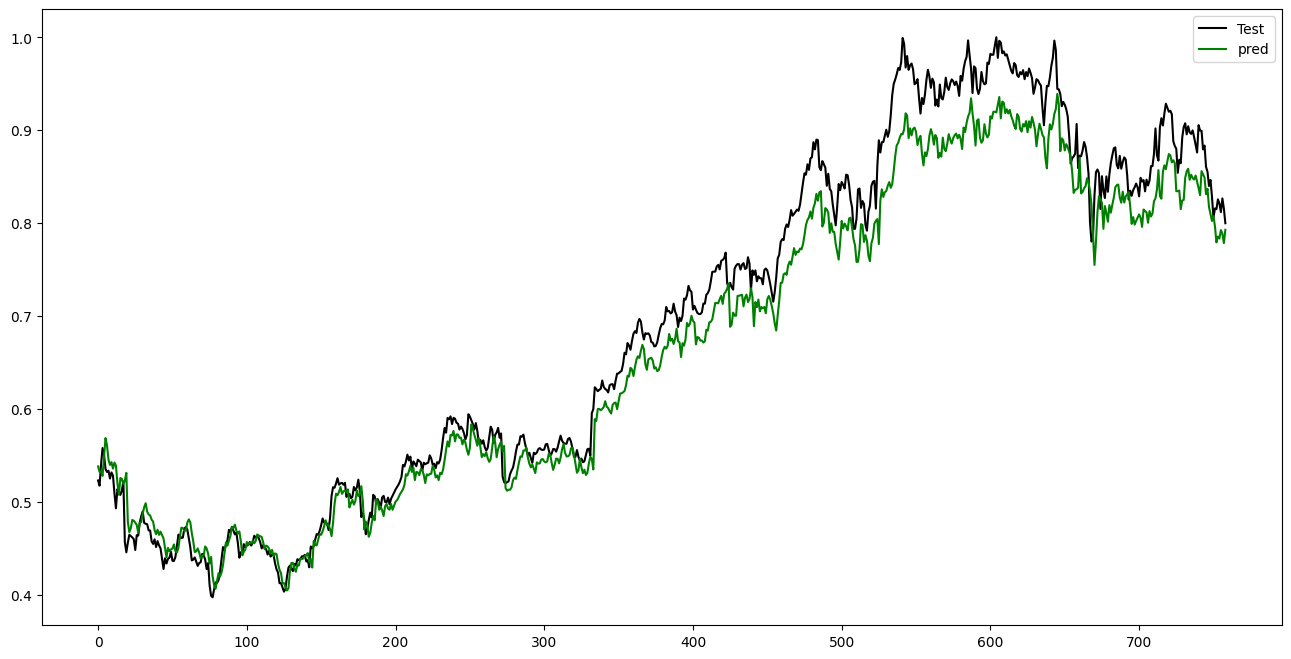

In [21]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

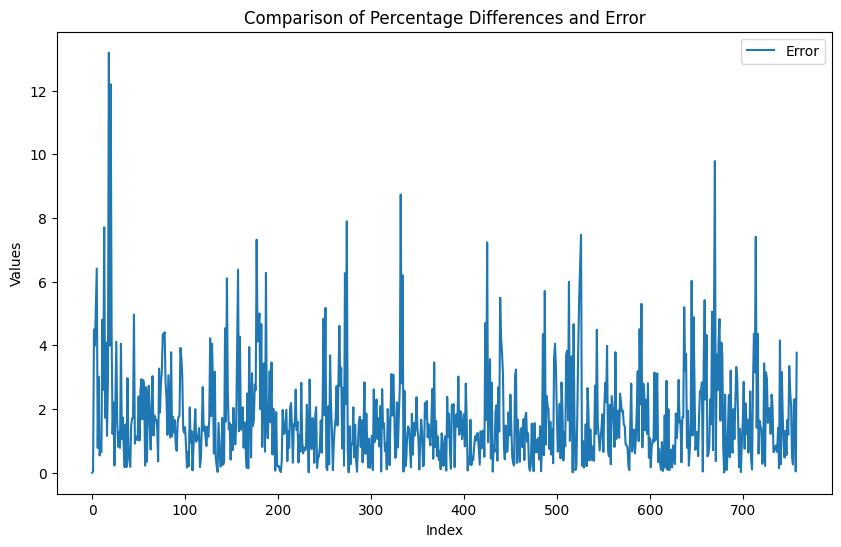

In [29]:

# Assuming you already have y_test and y_pred defined
# Create a DataFrame
model_test_out_df = pd.DataFrame({
    'y_test': y_test.flatten(),  # Flattening in case y_test is a multi-dimensional array
    'y_pred': y_pred.flatten()   # Flattening in case y_pred is a multi-dimensional array
})

# Calculate percentage difference for y_test and y_pred
model_test_out_df['pct_diff_y_test'] = model_test_out_df['y_test'].pct_change() * 100
model_test_out_df['pct_diff_y_pred'] = model_test_out_df['y_pred'].pct_change() * 100

# Handle the first row for percentage difference
model_test_out_df.iloc[0, model_test_out_df.columns.get_loc('pct_diff_y_test')] = 0
model_test_out_df.iloc[0, model_test_out_df.columns.get_loc('pct_diff_y_pred')] = 0

# Calculate error between percentage differences
model_test_out_df['error'] = abs(model_test_out_df['pct_diff_y_test'] - model_test_out_df['pct_diff_y_pred'])

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(model_test_out_df['pct_diff_y_test'], label='Percentage Difference y_test')
# plt.plot(model_test_out_df['pct_diff_y_pred'], label='Percentage Difference y_pred')
plt.plot(model_test_out_df['error'], label='Error')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Percentage Differences and Error')
plt.legend()
plt.show()




In [30]:
model_test_out_df.head()

,y_test,y_pred,pct_diff_y_test,pct_diff_y_pred,error
0,0.522936,0.538098,0.000000,0.000000,0.000000
1,0.517311,0.532126,-1.075613,-1.109827,0.034214
2,0.540530,0.532062,4.488291,-0.012028,4.500319
3,0.557866,0.527889,3.207355,-0.784415,3.991770
4,0.550740,0.548823,-1.277411,3.965652,5.243063
